In [113]:
import jwst
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import match_coordinates_sky,SkyCoord, Angle
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

band = "f444w"
path = "../../ngc3324/NIRCAM_ALL/JWST/jw02731-o001_t017_nircam_"

In [2]:
t = Table.read(path+"clear-"+band+"/jw02731-o001_t017_nircam_clear-"+band+"_cat.ecsv")

t.info()

<Table length=19438>
         name           dtype    unit  format                                                                  description                                                                    class   n_bad
---------------------- ------- ------- ------ ---------------------------------------------------------------------------------------------------------------------------------------------- -------- -----
                 label   int64                                                                                                                     Unique source identification label number   Column     0
             xcentroid float64            .4f                                                                                                           X pixel value of the source centroid   Column     0
             ycentroid float64            .4f                                                                                                           Y pixel val

To brute force make a catalogue:

1) Start with the filter that has the most sources
2) Take the brightest source, grab it's RA/DEC, relate the size of it's 1-sigma psf size to deg and use this as tolerance.
3) Find all other objects in all other filters that are located within this tolerance
4) Take those filter mags/fluxes and plop into new dataframe
5) If one source has multiple objects associated with it in other filters, add them all into the rows and add a flag

In [7]:

path = "../../ngc3324/NIRCAM_ALL/JWST/jw02731-o001_t017_nircam_"
t = []
skyco = []
for i, band in enumerate(['clear-f090w', 'clear-f187n', 'clear-f200w', 'clear-f335m', 'clear-f444w', 'f444w-f470n']):
    # Get the tables
    t.append(Table.read(path+band+"/jw02731-o001_t017_nircam_"+band+"_cat.ecsv"))
    print(len(t[i]))
    # Make lists of all the skycoords over all the tables
    skyco.append(t[i]['sky_centroid'])



20401
32372
44867
16663
19438
18984


In [8]:

# data_S = data_s[['RA', 'DEC', ap_type+'_'+meas_type+'_f200w', ap_type+'_'+meas_type+'_err_f200w', 'size']]
# data_S.sort_values(ap_type+'_'+meas_type+'_f200w',ascending=True,inplace=True)
# data_S.reset_index(drop=True,inplace=True)
# data_S

In [9]:
meas_type = 'vegamag'
ap_type = 'isophotal'

for i, f in enumerate(['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n']):
    if i < 3:
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.031/3600 # Convert pixels to arcseconds, arcseconds to degrees
    else:
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.063/3600
    
    t[i] = t[i].to_pandas()[['sky_centroid.ra', 'sky_centroid.dec', ap_type+'_'+meas_type, ap_type+'_'+meas_type+'_err','size']]
    t[i].rename(columns={'sky_centroid.ra': 'RA', 'sky_centroid.dec': 'DEC',ap_type+'_'+meas_type:ap_type+'_'+meas_type+'_'+f, ap_type+'_'+meas_type+'_err': ap_type+'_'+meas_type+'_err_'+f},inplace=True)

data_all_filters_NIRCam = pd.concat([t[0],t[1],t[2],t[3],t[4],t[5]],ignore_index=True)
data_all_filters_NIRCam.sort_values(ap_type+'_'+meas_type+'_f444w', ascending=True,inplace=True)
data_all_filters_NIRCam.reset_index(drop=True,inplace=True)

In [10]:
data_all_filters_NIRCam

,RA,DEC,aper50_vegamag_f090w,aper50_vegamag_err_f090w,size,aper50_vegamag_f187n,aper50_vegamag_err_f187n,aper50_vegamag_f200w,aper50_vegamag_err_f200w,aper50_vegamag_f335m,aper50_vegamag_err_f335m,aper50_vegamag_f444w,aper50_vegamag_err_f444w,aper50_vegamag_f444w-f470n,aper50_vegamag_err_f444w-f470n
0,159.214611,-58.642730,NaN,NaN,0.000066,NaN,NaN,NaN,NaN,NaN,NaN,14.525271,6.347405,NaN,NaN
1,159.176273,-58.662852,NaN,NaN,0.000067,NaN,NaN,NaN,NaN,NaN,NaN,14.543779,6.922695,NaN,NaN
2,159.252466,-58.631198,NaN,NaN,0.000105,NaN,NaN,NaN,NaN,NaN,NaN,14.575262,8.302190,NaN,NaN
3,159.258844,-58.615967,NaN,NaN,0.000097,NaN,NaN,NaN,NaN,NaN,NaN,14.583888,6.736452,NaN,NaN
4,159.228378,-58.609559,NaN,NaN,0.000047,NaN,NaN,NaN,NaN,NaN,NaN,14.600097,6.376051,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152720,159.296183,-58.593406,NaN,NaN,0.000021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.900061,14.765570
152721,159.287218,-58.613990,NaN,NaN,0.000023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.147950,15.775395
152722,159.303201,-58.577420,NaN,NaN,0.000033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.411682,NaN
152723,159.291852,-58.603410,NaN,NaN,0.000017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.365494,15.486526


In [12]:
def strip_cand(df, tol=1/3600):
    """
    Originally written by S. Smith, UVic 2022, edited by B. Crompvoets UVic 2022

    For a pandas dataframe filled with unsorted candidates, 
    select the first row, select all neighbours within the df, 
    and keep only the most significant. Strip all neighbours and 
    reference source from the original df. Return the striped df, 
    along with the row values of the most significant member.
    
    Parameters:
    -----------
    
    df  : Pandas DataFrame object, candidates
    tol : Neighbour tollerance, in degrees (recommended, tol = 0.5)
    
    Returns:
    -----------
    
    rest  : Pandas Dataframe object, striped of one candidate member group
    row : Numpy Array object, highest significance candidate from group
    """
    
    i, j = df.iloc[0]['RA'], df.iloc[0]['DEC'] #Select RA/Dec of first item in the df
    prox = np.sqrt((df['RA']-i)**2 + (df['DEC']-j)**2) < tol #Find boolean locations of all neighbours within tol (in degrees)
    invest = df[prox].sort_values(ap_type+'_'+meas_type+'_f444w', ascending=True).reset_index(drop=True) #Define new df 'investigate' made up of all group members
    #row = np.array(invest.iloc[0]) #Take highest sig group member and put in np.array object
    rest = df[~prox].reset_index(drop=True) #Define new df 'the rest' made up of all the other rows
    
    return rest, invest

In [13]:
%timeit
length = True
i = 0

rest, row = strip_cand(data_all_filters_NIRCam,tol=data_all_filters_NIRCam['size'])

for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n']:
    if not row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy():
        row.loc[0,ap_type+'_'+meas_type+'_'+f] = np.nan
        row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = np.nan
    else:
        row.loc[0,ap_type+'_'+meas_type+'_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy()[0]
        row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_err_'+f)[ap_type+'_'+meas_type+'_err_'+f].to_numpy()[0]

catalog = row.head(1)

while length:
    rest, row = strip_cand(rest,tol=rest['size'])
    
    for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n']:
        if not row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy().any():
            row.loc[0,ap_type+'_'+meas_type+'_'+f] = np.nan
            row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = np.nan
        else:
            row.loc[0,ap_type+'_'+meas_type+'_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_'+f)[ap_type+'_'+meas_type+'_'+f].to_numpy()[0]
            if not row.dropna(subset=ap_type+'_'+meas_type+'_err_'+f)[ap_type+'_'+meas_type+'_err_'+f].to_numpy().any():
                row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = np.nan
            else:
                row.loc[0,ap_type+'_'+meas_type+'_err_'+f] = row.dropna(subset=ap_type+'_'+meas_type+'_err_'+f)[ap_type+'_'+meas_type+'_err_'+f].to_numpy()[0]
    
    row = row.head(1)

    catalog = pd.concat([catalog, row])

    length = len(rest) > 0
    if i % 10000 == 0:
        print(len(rest))
    i = i+1
catalog.reset_index(inplace=True,drop=True)

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_20773/3233750031.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not row.dropna(subset='aper50_'+meas_type+'_'+f)['aper50_'+meas_type+'_'+f].to_numpy():


152713
116447
96989
81235
67440
56181
45523
35282
25146
15010
4850


In [14]:
print(i)

104851


In [15]:
catalog.reset_index(inplace=True,drop=True)
print(len(catalog))
catalog

104852


,RA,DEC,aper50_vegamag_f090w,aper50_vegamag_err_f090w,size,aper50_vegamag_f187n,aper50_vegamag_err_f187n,aper50_vegamag_f200w,aper50_vegamag_err_f200w,aper50_vegamag_f335m,aper50_vegamag_err_f335m,aper50_vegamag_f444w,aper50_vegamag_err_f444w,aper50_vegamag_f444w-f470n,aper50_vegamag_err_f444w-f470n
0,159.214611,-58.642730,18.209974,12.734806,0.000066,NaN,NaN,18.805103,9.471206,25.804434,16.803808,14.525271,6.347405,14.266360,10.327788
1,159.176273,-58.662852,18.338603,12.202362,0.000067,NaN,NaN,18.020400,11.911766,14.841529,10.656911,14.543779,6.922695,14.442614,10.620114
2,159.252466,-58.631198,NaN,NaN,0.000105,NaN,NaN,18.029207,11.771293,14.874616,10.548925,14.575262,8.302190,14.465839,10.507919
3,159.258844,-58.615967,20.105844,12.234682,0.000097,NaN,NaN,20.899423,12.839444,16.437993,9.744038,14.583888,6.736452,14.247898,10.381843
4,159.228378,-58.609559,20.803989,12.480124,0.000047,NaN,NaN,16.093340,8.659518,15.445085,8.050746,14.600097,6.376051,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104847,159.292665,-58.601397,NaN,NaN,0.000017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.649381,16.030067
104848,159.296183,-58.593406,NaN,NaN,0.000021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.900061,14.765570
104849,159.287218,-58.613990,NaN,NaN,0.000023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.147950,15.775395
104850,159.291852,-58.603410,NaN,NaN,0.000017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.365494,15.486526


In [16]:
rest.columns

Index(['RA', 'DEC', 'aper50_vegamag_f090w', 'aper50_vegamag_err_f090w', 'size',
       'aper50_vegamag_f187n', 'aper50_vegamag_err_f187n',
       'aper50_vegamag_f200w', 'aper50_vegamag_err_f200w',
       'aper50_vegamag_f335m', 'aper50_vegamag_err_f335m',
       'aper50_vegamag_f444w', 'aper50_vegamag_err_f444w',
       'aper50_vegamag_f444w-f470n', 'aper50_vegamag_err_f444w-f470n'],
      dtype='object')

In [17]:
catalog_tab = Table.from_pandas(catalog[['RA','DEC','size',ap_type+'_'+meas_type+'_f090w', ap_type+'_'+meas_type+'_err_f090w', ap_type+'_'+meas_type+'_f187n', ap_type+'_'+meas_type+'_err_f187n',\
    ap_type+'_'+meas_type+'_f200w', ap_type+'_'+meas_type+'_err_f200w',ap_type+'_'+meas_type+'_f335m', ap_type+'_'+meas_type+'_err_f335m',ap_type+'_'+meas_type+'_f444w', ap_type+'_'+meas_type+'_err_f444w',\
        ap_type+'_'+meas_type+'_f444w-f470n', ap_type+'_'+meas_type+'_err_f444w-f470n']],units={'RA':'deg','DEC':'deg',ap_type+'_'+meas_type+'_f090w':'mag',ap_type+'_'+meas_type+'_err_f090w':'mag','size':'deg',\
            ap_type+'_'+meas_type+'_f187n':'mag',ap_type+'_'+meas_type+'_err_f187n':'mag',ap_type+'_'+meas_type+'_f200w':'mag',ap_type+'_'+meas_type+'_err_f200w':'mag',\
                ap_type+'_'+meas_type+'_f335m':'mag',ap_type+'_'+meas_type+'_err_f335m':'mag',ap_type+'_'+meas_type+'_f444w':'mag',ap_type+'_'+meas_type+'_err_f444w':'mag',\
                    ap_type+'_'+meas_type+'_f444w-f470n':'mag',ap_type+'_'+meas_type+'_err_f444w-f470n':'mag'})


catalog_tab

NameError: name 'ap_type' is not defined

In [ ]:

# catalog_tab.write('CC_JWST_Full_Nov042022_'+meas_type+'.ecsv', format='ascii.ecsv',overwrite=True)
# catalog.to_csv('CC_JWST_Full_Nov042022_'+meas_type+'.csv')

# Now that we have a catalogue of all JWST data, link Spitzer/2MASS

In [54]:
# jwst_cat = pd.read_csv('CC_JWST_Full_Nov042022.csv')
jwst_cat = catalog
spit2m_cat = pd.read_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/NGC_3324_w_Preds.csv')
spicy_cat = pd.read_csv('/Users/breannacrompvoets/Documents/Star_Formation/YSO+Classification/Archive/SPICY_YSO_SubClasses.csv',comment='#')

j_sky = SkyCoord(jwst_cat.RA*u.deg, jwst_cat.DEC*u.deg)
# # jwst_cat.drop(['RA','DEC'], axis=1, inplace=True)
s2_sky = SkyCoord(spit2m_cat[.RAJ2000*u.deg, spit2m_cat.DEJ2000*u.deg])
sp_sky = SkyCoord(spicy_cat['     RAdeg      DEdeg'].to_numpy(),unit=u.deg)
# # spit2m_cat.drop(['RAJ2000','DEJ2000'], axis=1, inplace=True)


# print(jwst_cat.shape)
# print(spit2m_cat.shape)


In [55]:
idx, sep2d, x = match_coordinates_sky(j_sky, s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
sep_constraint = sep2d < np.array(jwst_cat['size']*2)*u.deg

print(np.count_nonzero(sep_constraint))

j_matches = jwst_cat[sep_constraint]
s2_matches = spit2m_cat.iloc[idx[sep_constraint]]

j_matches.reset_index(drop=True,inplace=True)
s2_matches.reset_index(drop=True,inplace=True)

jwst_spitz_cat = pd.concat([j_matches,s2_matches],axis=1)


# jwst_spitz_cat[['size','RA','DEC','RAJ2000','DEJ2000',ap_type+'_'+meas_type+'_f444w','mag_IR2']].head()

37


(array([0., 0., 0., 2., 1., 3., 2., 4., 1., 0., 0., 0., 0., 0.]),
 array([-20.        , -17.85714286, -15.71428571, -13.57142857,
        -11.42857143,  -9.28571429,  -7.14285714,  -5.        ,
         -2.85714286,  -0.71428571,   1.42857143,   3.57142857,
          5.71428571,   7.85714286,  10.        ]),
 <BarContainer object of 14 artists>)

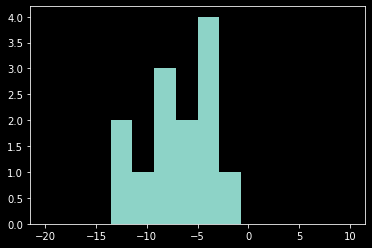

In [56]:
ap_type = 'aper50'
plt.hist(jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],bins=np.linspace(-20,10,15))
# idx_1, sep2d_1, _ = match_coordinates_sky(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)), s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
# print(sep2d_1)
# spit2m_cat.iloc[idx_1]


In [63]:
# print(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)))
# idx_2, sep2d_2, _ = match_coordinates_sky(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)), j_sky, nthneighbor=1, storekdtree='kdtree_sky')
# jwst_cat.iloc[idx_2]

jwst_spitz_cat.rename({'class    ':'Preds'},axis=1,inplace=True)

jwst_spitz_cat.columns

Index(['RA', 'DEC', 'aper50_vegamag_f090w', 'aper50_vegamag_err_f090w', 'size',
       'aper50_vegamag_f187n', 'aper50_vegamag_err_f187n',
       'aper50_vegamag_f200w', 'aper50_vegamag_err_f200w',
       'aper50_vegamag_f335m', 'aper50_vegamag_err_f335m',
       'aper50_vegamag_f444w', 'aper50_vegamag_err_f444w',
       'aper50_vegamag_f444w-f470n', 'aper50_vegamag_err_f444w-f470n',
       ' SPICY', '     RAdeg      DEdeg', '      GLON      GLAT', 'p1', 'p2',
       'p3', 'Preds', 'Si', 'PAH', 'alpha', 'alpha8', 'alpha24', 'alphaW4',
       'Env    ', 'Group     ', 'r', 'mag', 'ZTFrmag', 'TFrmag', '   skew',
       'Spitzer                   ', 'mag_IR1', 'e_mag_IR1', 'mag_IR2',
       'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4', 'f', 'ag',
       'ag.1', 'ag.2', 'ag.3', '2MASS', 'UKIDSS             ', '    VIRAC',
       'GaiaDR2', 'MIPS              ', 'WISEA              ', 'ZTFDR3'],
      dtype='object')

['ClassI   ' 'ClassII  ' 'FS       ' 'uncertain']


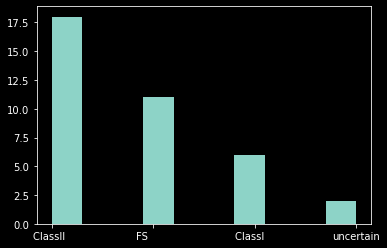

In [65]:
plt.hist(jwst_spitz_cat.Preds)

print(np.unique(jwst_spitz_cat.Preds))

# Locate all IR-Excess sources from Reiter 2022:


In [66]:
# IR-Excess sources found in Reiter 2022 (Diving off the Cosmic Cliffs)
reit = ["10:36:42.3 -58:38:04", "10:36:48.0 -58:38:19", "10:36:47.3 -58:38:10", "10:36:46.7 -58:38:05", "10:36:51.5 -58:37:54", "10:36:50.5 -58:37:52",\
    "10:36:51.4 -58:37:48", "10:36:53.8 -58:37:48", "10:36:51.5 -58:37:10", "10:36:54.2 -58:36:26", "10:36:54.4 -58:36:18", "10:36:54.0 -58:37:20",\
        "10:36:53.6 -58:35:20", "10:36:53.1 -58:37:37", "10:36:53.3 -58:37:54", "10:36:52.7 -58:38:05", "10:36:53.1 -58:37:08", "10:36:51.6 -58:36:58",\
        "10:36:52.3 -58:38:09", "10:36:53.9 -58:36:29", "10:37:01.5 -58:37:51", "10:37:02.1 -58:36:58", "10:36:53.9 -58:36:32"]# End of third row is the end of MHO-only sources
sky_1 = SkyCoord(reit,unit=(u.hourangle, u.deg))
ra_1 = sky_1.ra
dec_1 = sky_1.dec

reit_eg = ["10:36:53.7 -58:35:47", "10:36:59.5 -58:39:01", "10:37:07.2 -58:35:36", "10:36:55.2 -58:38:09"]
sky_1 = SkyCoord(reit_eg,unit=(u.hourangle, u.deg))
ra_eg = sky_1.ra
dec_eg = sky_1.dec


spicy = ["10:36:47.3 -58:38:10","10:36:54.0 -58:37:20","10:36:53.9 -58:36:29","10:37:02.1 -58:36:58","10:36:53.3 -58:37:54","10:36:52.3 -58:38:09"]
sky_1 = SkyCoord(spicy,unit=(u.hourangle, u.deg))
ra_spicy = sky_1.ra
dec_spicy = sky_1.dec

159.09784709430238


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574327 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654444171.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

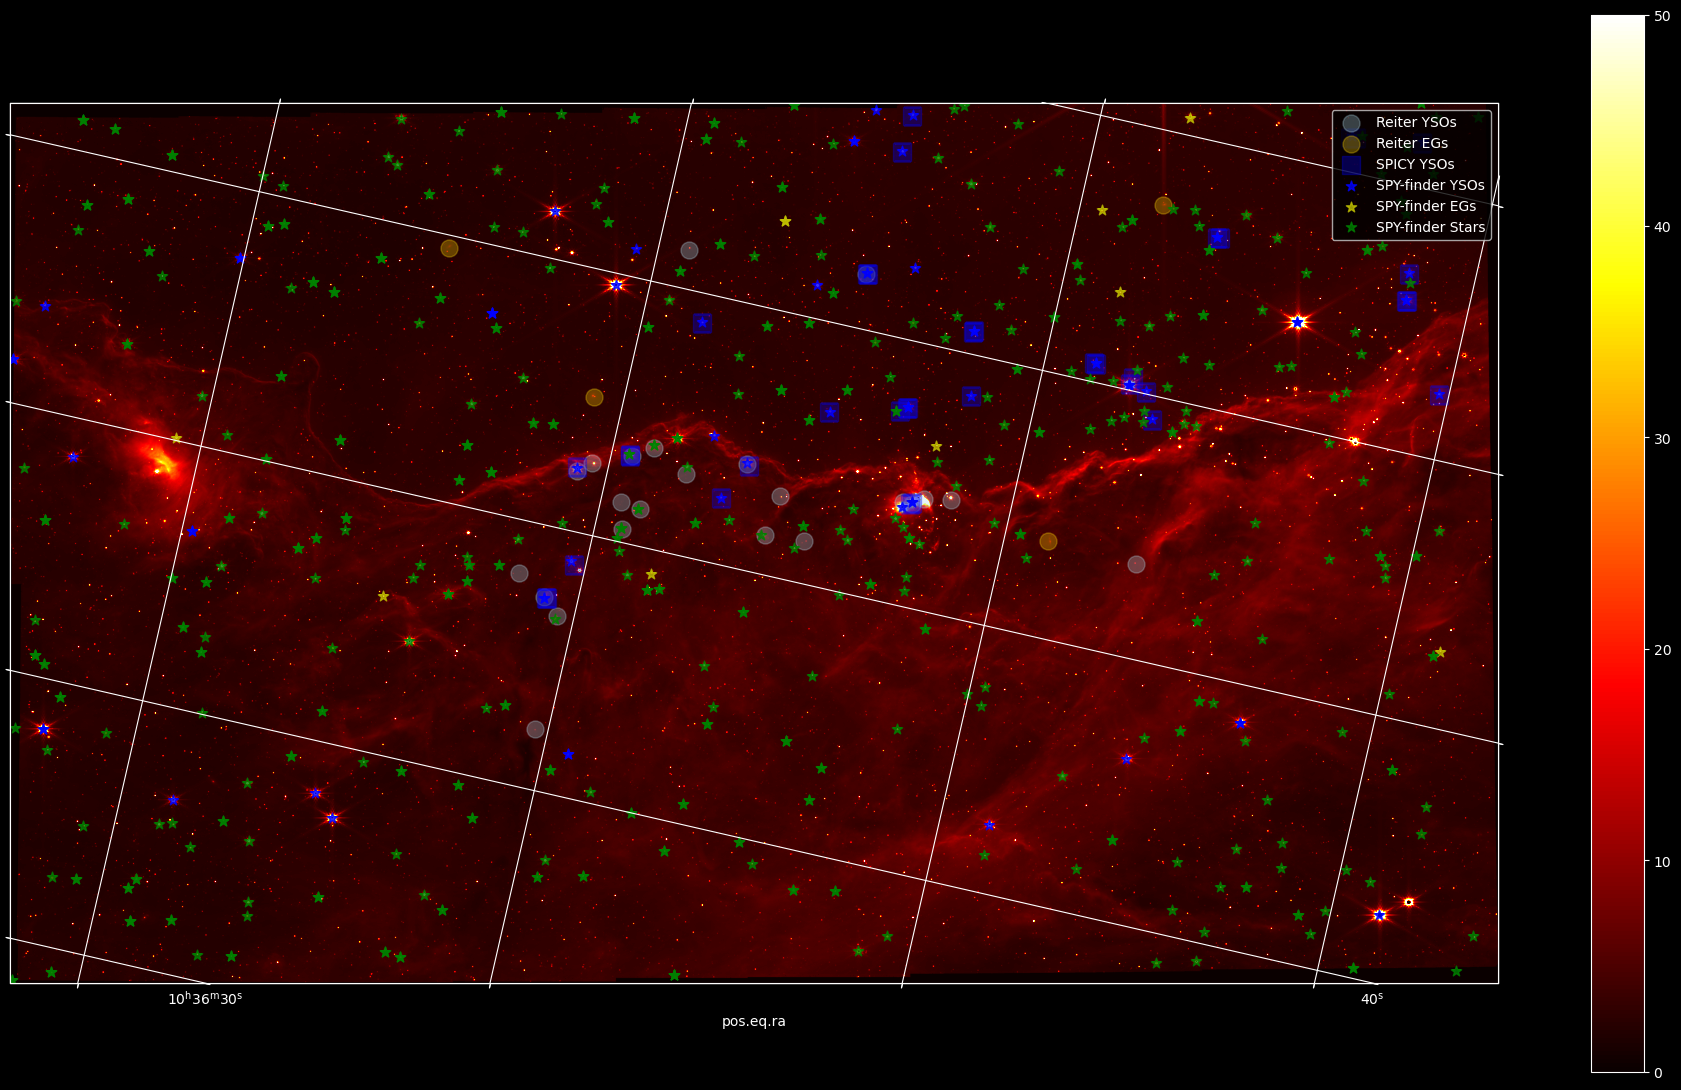

In [70]:
# Plot image
filter = "f444w"
image_file = f"../../ngc3324/FITS/JWST_{filter}.fits"


h = fits.getheader(image_file)

f = fits.open(image_file)

wcs = WCS(f[1].header)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(24,14),dpi=100)
ax = plt.subplot(projection=wcs)

plt.grid(color='white', ls='solid')
plt.imshow(f[1].data,cmap='hot',vmin=0,vmax=50,origin='lower') #vmax =1500 for f1800w
ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()
plt.colorbar()

ras, decs = wcs.wcs_pix2world(np.linspace(-500,15000,100), np.linspace(-500,16000,100), 1)
print(min(ras))

# np8 = np.c_[np.array(jwst_spitz_cat.RAJ2000),np.array(jwst_spitz_cat.DEJ2000),np.array(jwst_spitz_cat.mag_IR2),np.array(jwst_spitz_cat.Preds)]

yso = np.where(np8[:,-1]==0)[0]
egs = np.where(np8[:,-1]==1)[0]
sta = np.where(np8[:,-1]==2)[0]

plt.scatter(ra_1,dec_1, marker='o', c='lightblue',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='Reiter YSOs')
plt.scatter(ra_eg,dec_eg, marker='o', c='gold',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='Reiter EGs')
plt.scatter(np.array(jwst_spitz_cat.RA),np.array(jwst_spitz_cat.DEC), marker='s', c='b',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='SPICY YSOs')
# plt.scatter(ra_spicy,dec_spicy, marker='s', c='b',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='SPICY YSOs')
ax.scatter(np8[yso,0],np8[yso,1], marker='*', c='b',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder YSOs")
ax.scatter(np8[egs,0],np8[egs,1], marker='*', c='y',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder EGs")
ax.scatter(np8[sta,0],np8[sta,1], marker='*', c='g',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder Stars")
ax.set_ylim(ymax, ymin)
ax.set_xlim(xmax, xmin)
plt.legend(loc=1)
plt.xticks()

# plt.savefig(f"../../ngc3324/CC_w_Reiter_RF_Label_{filter}.png",dpi=100)


In [48]:
# jwst_spitz_cat.to_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/CC_Webb_Spitz_2m_w_Preds.csv')

In [155]:
# print('J'+np.array(jwst_spitz_cat.RA)+np.array(jwst_spitz_cat.DEC))
def deg_to_hrminsec(deg):
    deg = deg*u.deg
    h = deg.to(u.hourangle)/u.hourangle
    m = (h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:04.1f}".format(s)
def deghr_to_hrminsec(deg):
    h = deg
    # print(Angle(deg,u.hourangle).hms)
    m = 60-(h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:02d}".format(int(s))

jwst_num = []


for i, r in enumerate(np.array(jwst_spitz_cat.RA)):
    jwst_num.append('J'+deg_to_hrminsec(r)+deghr_to_hrminsec(np.array(jwst_spitz_cat.DEC)[i]))

In [163]:

jwst_spitz_cat['JWST_NUM'] = jwst_num
jwst_spitz_cat[['JWST_NUM',' SPICY', 'Preds']]

# print(jwst_spitz_cat[['JWST_NUM',' SPICY']])
# for i, r in enumerate(np.array(jwst_spitz_cat.RA)):

,JWST_NUM,SPICY,Preds
0,J103702.1-583657,7467,ClassII
1,J103700.3-583533,7461,FS
2,J103702.5-583403,7469,ClassI
3,J103658.9-583742,7452,ClassII
4,J103656.6-583659,7444,ClassII
5,J103657.4-583637,7447,ClassII
6,J103653.3-583754,7438,uncertain
7,J103652.5-583725,7435,ClassI
8,J103652.4-583809,7434,ClassI
9,J103653.9-583629,7440,FS
